# Learning Rate scheduling in pytorch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import numpy as np

### Preparing DataLoaders

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=16)
test_dataloader = DataLoader(test_data, batch_size=16)
# # Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

100%|██████████| 26.4M/26.4M [00:18<00:00, 1.40MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 152kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.69MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

### Exponential learning rate decay

In [4]:
learning_rate = 1e-3
batch_size = 16
epochs = 5

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

decayRate = 0.96
exp_decay_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

### Defining Training and Testing Loop

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            train_loss.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    exp_decay_lr_scheduler.step()
    return np.average(train_loss)

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

### Model training

In [6]:
train_losses, val_losses = [], []

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    avg_test_loss = test_loop(test_dataloader, model, loss_fn)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_test_loss)

print("Done!")


Epoch 1
-------------------------------
loss: 2.299750  [    0/60000]
loss: 2.288007  [ 1600/60000]
loss: 2.284567  [ 3200/60000]
loss: 2.266864  [ 4800/60000]
loss: 2.262115  [ 6400/60000]
loss: 2.249012  [ 8000/60000]
loss: 2.222714  [ 9600/60000]
loss: 2.204840  [11200/60000]
loss: 2.209761  [12800/60000]
loss: 2.175430  [14400/60000]
loss: 2.169753  [16000/60000]
loss: 2.149850  [17600/60000]
loss: 2.136507  [19200/60000]
loss: 2.117780  [20800/60000]
loss: 2.113198  [22400/60000]
loss: 2.048277  [24000/60000]
loss: 2.010254  [25600/60000]
loss: 2.093750  [27200/60000]
loss: 1.976246  [28800/60000]
loss: 1.971360  [30400/60000]
loss: 1.854783  [32000/60000]
loss: 1.820587  [33600/60000]
loss: 1.716433  [35200/60000]
loss: 1.831032  [36800/60000]
loss: 1.880657  [38400/60000]
loss: 1.671282  [40000/60000]
loss: 1.645874  [41600/60000]
loss: 1.725422  [43200/60000]
loss: 1.456807  [44800/60000]
loss: 1.546247  [46400/60000]
loss: 1.623062  [48000/60000]
loss: 1.389457  [49600/60000]


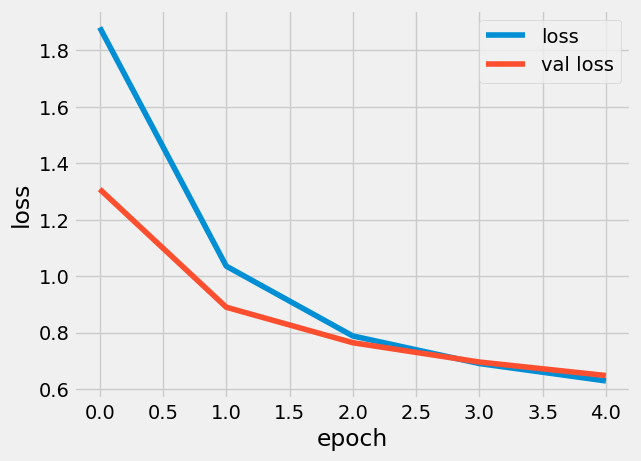

In [7]:
#loss plot
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.plot(train_losses,label='loss')
plt.plot(val_losses,label='val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

# Learning rate scheduling with TensorFlow(Keras)

In [3]:
import tensorflow as tf
from sklearn import model_selection as ms

# here we import Sequential where we can add or stack different layer of neural network
from tensorflow.keras.models import Sequential
# Dense layer implements operation = activation(dot(input,weight)+bias)
from tensorflow.keras.layers import Dense, Softmax, Dropout

tf.__version__

'2.19.0'

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(-1,28*28)/255
x_test = x_test.reshape(-1,28*28)/255
x_train,x_val,y_train,y_val=ms.train_test_split(x_train,y_train,test_size=0.2,random_state=42)
print("Train",x_train.shape,y_train.shape)
print("Test",x_test.shape,y_test.shape)
print("Validation",x_val.shape,y_val.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train (48000, 784) (48000,)
Test (10000, 784) (10000,)
Validation (12000, 784) (12000,)


### Define Model (classifier)

In [5]:
#defining number of neurons at different layer, number of layer ,input and output size
#why input size is 784 and output is 10? discussed above
input_size=784
hidden_1_shape=256
hidden_2_shape=128
hidden_3_shape=50
output_size=10


model=Sequential([Dense(hidden_1_shape,input_shape=(input_size,), activation="relu"),
                  Dropout(0.2),
                  Dense(hidden_2_shape, activation="relu"),
                  Dropout(0.2),
                  Dense(hidden_3_shape, activation="relu"),
                  Dropout(0.2),
                  Dense(output_size),
                  Softmax()])

C:\Users\Dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Implement Exponential Learning Rate Decay in optimizer

In [6]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                             decay_steps=20,
                                                             decay_rate=0.96,   # 0.1 * 0.96 = new_learning_rate
                                                             staircase=True)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,816 (940.69 KB)

 Trainable params: 240,816 (940.69 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#training model
history = model.fit(x_train,y_train,batch_size=128,
          validation_data=(x_val,y_val),epochs=5)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5971 - loss: 1.1254 - val_accuracy: 0.8112 - val_loss: 0.5331
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7857 - loss: 0.6046 - val_accuracy: 0.8286 - val_loss: 0.4799
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8069 - loss: 0.5489 - val_accuracy: 0.8334 - val_loss: 0.4605
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8133 - loss: 0.5275 - val_accuracy: 0.8364 - val_loss: 0.4518
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8183 - loss: 0.5187 - val_accuracy: 0.8369 - val_loss: 0.4489


In [8]:
# calculating total loss and accuracy in test set
loss, accuracy=model.evaluate(x=x_test, y=y_test, batch_size=128,verbose=2)
print('loss = ',loss, ', accuracy = ',accuracy)

79/79 - 0s - 3ms/step - accuracy: 0.8307 - loss: 0.4653
loss =  0.4652872681617737 , accuracy =  0.8306999802589417


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


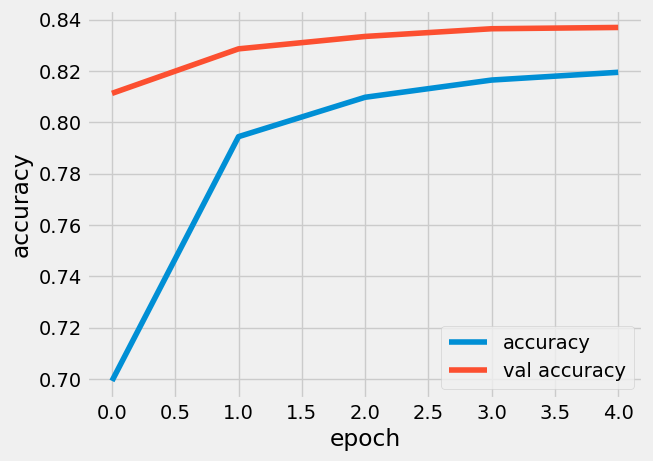

In [9]:
# predicting value at final layer for each example
prediction=model.predict(x_test)
# choosing class with highest probability
predicted=tf.argmax(prediction,axis=1)
predicted.shape

# accuracy plots.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

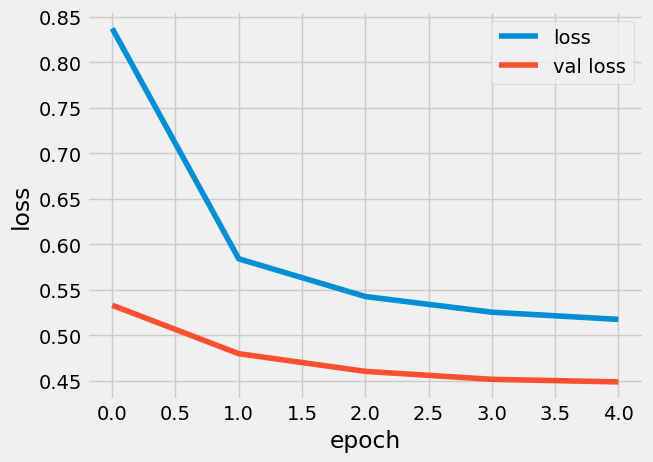

In [10]:
#loss plot
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()